# Работа с данными

датасеты - https://neurohive.io/ru/datasety/datasety-dlya-generacii-i-analiza-muzyki/

maestro - https://magenta.tensorflow.org/datasets/maestro#dataset

работа с MIDI - https://www.tensorflow.org/tutorials/audio/music_generation

In [1]:
#%%capture
#! pip install --upgrade pyfluidsynth
#! pip install pretty_midi
#! pip install pyfluidsynth

Задача проекта - написать модель, которая будет генерировать музыку. Наша модель обучается на midi-файлах датасета Maestro. На выходе наша модель также будет выдавать сгенерированный midi-файл.

Для начала поработаем с MIDI-файлами для пианино из датасета MAESTRO. Основываясь на последовательности нот, модель будет обучена предсказывать следующую ноту в этой последовательности. Используя модель многократно, мы сможете создавать удлиненные последовательности нот.

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pathlib
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000


Скачиваем данные в папку data_dir и распаковываем их.

In [3]:
from data import load_to_folder

data_dir = pathlib.Path('data/maestro-v2.0.0')

filenames = load_to_folder(data_dir)

Количество скаченных midi-файлов: 1282


Возьмем рандомный MIDI файл и посмотрим на него.

In [4]:
from midi_and_notes import display_audio
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Также мы можем менять количество инструментов в мелодии и сами инструменты, так как midi-уникальный файл, в котором можем легко менять музыкальные инструменты.

In [5]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Каждая нота описывается характеристиками:

Базовые:
- pitch - каждому числу соответствует определённая нота с определённой высотой звука.
- start - время начала ноты
- end - время окончания ноты

Косвенные (выводятся из базовых):
- note_name - обозначение ноты
- step - время, прошедшее с предыдущей ноты или начала дорожки
- duration - продолжительность звучания ноты = end - start

In [6]:
from midi_and_notes import midi_to_notes

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,63,1.001302,1.079427,0.000000,0.078125
1,75,1.006510,1.074219,0.005208,0.067708
2,75,1.305990,1.350260,0.299479,0.044271
3,63,1.305990,1.352865,0.000000,0.046875
4,75,1.630208,1.671875,0.324219,0.041667


In [7]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

Также можем визуализировать мелодию или ее кусок, в дальнейшем это пригодится для анализа нормальности сгенерированного аудио

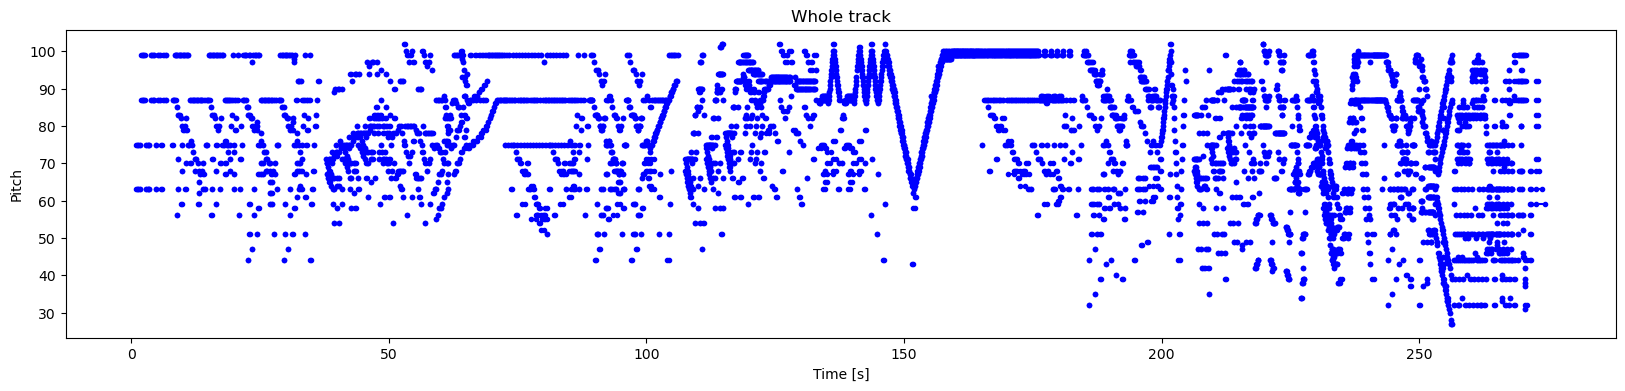

In [8]:
from data import plot_piano_roll
plot_piano_roll(raw_notes)

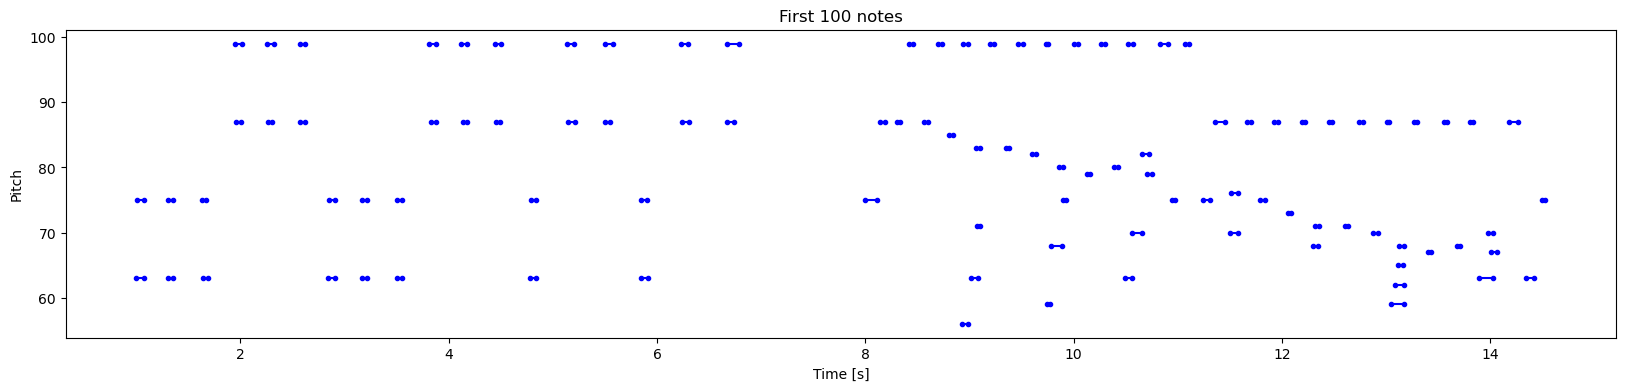

In [9]:
plot_piano_roll(raw_notes, count=100)

Теперь создадим датасет на основании всех наших midi-файлов из Maestro

In [10]:
from data import get_array_data
train_data = get_array_data(filenames)
print(f'всего мелодий в датасете = {len(train_data)}')

всего мелодий в датасете = 1282


In [11]:
train_data[1001]

,pitch,start,end,step,duration
0,62,1.009115,1.229167,0.000000,0.220052
1,62,1.454427,1.648438,0.445312,0.194010
2,62,1.929688,2.132812,0.475260,0.203125
3,55,2.380208,3.425781,0.450521,1.045573
4,59,3.317708,4.819010,0.937500,1.501302
...,...,...,...,...,...
867,62,167.026042,171.802083,0.832031,4.776042
868,38,167.042969,171.830729,0.016927,4.787760
869,57,167.046875,171.773438,0.003906,4.726562
870,54,167.048177,171.776042,0.001302,4.727865


In [12]:
from data import collate_fn_pad, SongsDataset

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

dataset = SongsDataset(train_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_pad)

Давайте перейдем непосредственно к построению VAE-GANа. Напомним, что VAE-GAN состоит из двух сетей генератора(VAE), задача которого – научиться генерировать аудио, похожие на обучающую выборку, из случайного шума, и дискриминатора, который учится распознавать, настоящее это аудио или сгенерированное генератором.

Обучение VAE-GAN состоит из нескольких ключевых этапов:

Энкодер (VAE часть): На первом этапе, энкодер принимает входные данные и отображает их в латентное пространство. Это пространство представляет сжатое представление входных данных. Энкодер обычно состоит из последовательности слоев нейронной сети.

Декодер (VAE часть): Затем, декодер берет сжатое представление из латентного пространства и пытается воссоздать исходные данные. Обучение VAE включает в себя минимизацию различий между входными данными и их воссозданными версиями, а также регуляризацию латентного пространства (через KL-дивергенцию).

Дискриминатор (GAN часть): Параллельно, дискриминатор, который также является нейронной сетью, обучается различать настоящие входные данные от данных, сгенерированных декодером. Дискриминатор пытается отличить "реальные" данные от "поддельных", а декодер (или генератор) старается обмануть дискриминатор, генерируя всё более реалистичные данные.

В процессе обучения VAE и GAN части модели обучаются одновременно, что позволяет создать эффективную генеративную модель, способную генерировать качественные и реалистичные данные.

Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные аудио и присваиваем им метку 1
  * генерируем аудио генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем аудио генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это аудио или нет

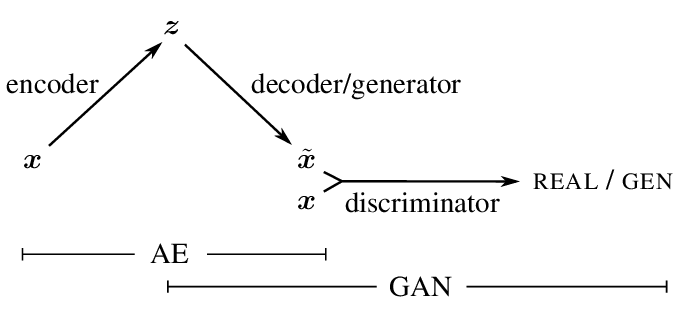

In [13]:
from IPython.display import Image
Image(filename='схема.png')

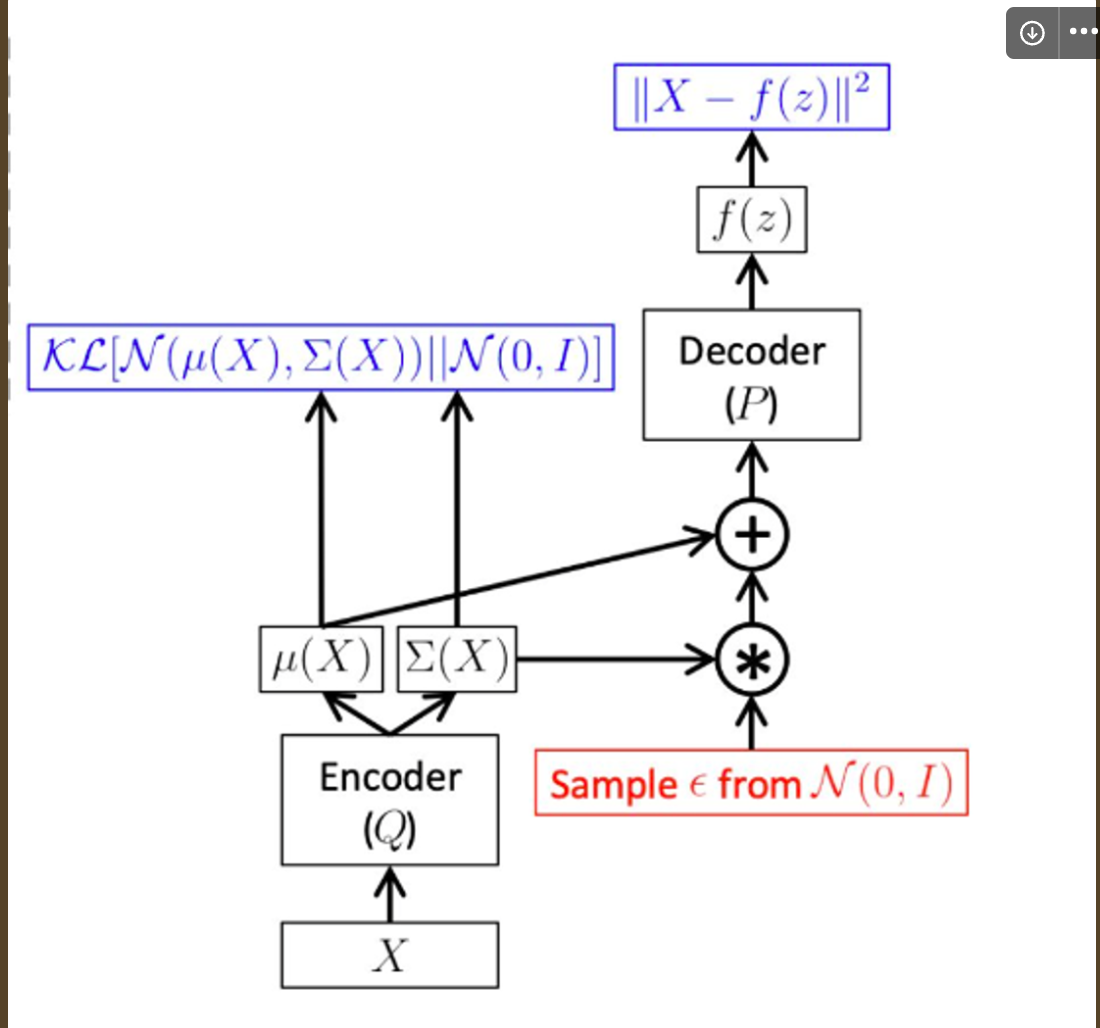

In [20]:
from IPython.display import Image
Image(filename='схемаVAE.png')

Про эффективность VAE-GAN:

в картинках - https://wandb.ai/shambhavicodes/vae-gan/reports/An-Introduction-to-VAE-GANs--VmlldzoxMTcxMjM5

https://github.com/rishabhd786/VAE-GAN-PYTORCH

в аудио -    https://habr.com/ru/companies/ruvds/articles/715258/

Вообще латентное пространство устроено очень интресно, а именно наши песни отображаются в латентное пространство с помощью encoder-а. И соответственно в этом пространстве каждая песня представляет из себя какую-то точку из этого пространства. Допустим мы отразили 2 песни в латентное простанство и теперь имеем 2 точки в нем - a(первая песня) и b(вторая песня). Соеденив две эти точки, мы получим вектор вдоль которого можно двигаться, тем самым, получая новую песню, как комбинацию a и b.

Ниже мы видим пример, как одно лицо из латентного пространства переходит в другое лицо. А по середине мы видим комбинацию этих двух лиц, которое генерирует наш VAE. Такой пример я нашла в материалах МФТИ - https://colab.research.google.com/drive/1TxwbGEY5FzoT-F6Z2su_p0RlgqanB-pY

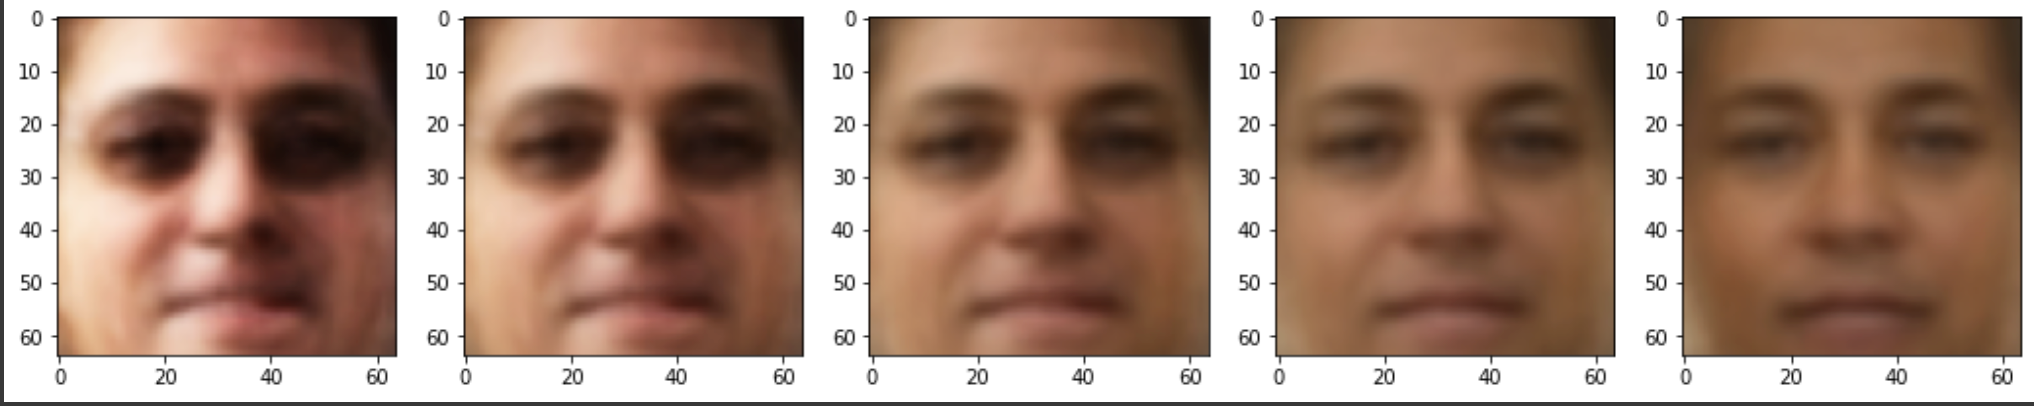

In [14]:
from IPython.display import Image
Image(filename='latent.png')

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from model import VAEGAN


model = VAEGAN(5 * 100, 100, 10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(model.discriminator.parameters(), lr=1e-3)

# Обучение модели
def train_model(model, data_loader, epochs=10):
    history_loss_d = []
    history_loss_g = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader):
            # Тренировка VAEGAN
            data = data.view(data.size(0), -1)
           
            # Обучение дискриминатора
            model.discriminator.zero_grad()
            real_data = data
            real_output = model.discriminator(real_data)
            fake_data, _, _ = model(data)
            fake_output = model.discriminator(fake_data.detach())
            d_loss = model.discriminator_loss(real_output, fake_output)
            d_loss.backward()
            discriminator_optimizer.step()

            # Обучение генератора и энкодера
            model.zero_grad()
            recon_data, mu, logsigma = model(data)
            g_loss = F.binary_cross_entropy(model.discriminator(recon_data), torch.ones_like(real_output))
            kl_loss = model.kl_loss(mu, logsigma)
            loss = g_loss + kl_loss
            loss.backward()
            optimizer.step()

            if i % 1 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
                history_loss_d.append(float(d_loss.item()))
                history_loss_g.append(float(g_loss.item()))
                
    return history_loss_d, history_loss_g


history_loss_d, history_loss_g = train_model(model, dataloader)

Epoch [1/10], Step [1/41], D Loss: 22.416236877441406, G Loss: 46.81365203857422
Epoch [1/10], Step [2/41], D Loss: 1.0687042474746704, G Loss: 0.6012343168258667
Epoch [1/10], Step [3/41], D Loss: 1.2670445442199707, G Loss: 0.5148301720619202
Epoch [1/10], Step [4/41], D Loss: 1.1626087427139282, G Loss: 0.49554330110549927
Epoch [1/10], Step [5/41], D Loss: 1.1930127143859863, G Loss: 0.45431146025657654
Epoch [1/10], Step [6/41], D Loss: 1.2987663745880127, G Loss: 0.41181910037994385
Epoch [1/10], Step [7/41], D Loss: 1.4212234020233154, G Loss: 0.4053563177585602
Epoch [1/10], Step [8/41], D Loss: 4.814850807189941, G Loss: 0.2967549264431
Epoch [1/10], Step [9/41], D Loss: 1.267547845840454, G Loss: 0.41208940744400024
Epoch [1/10], Step [10/41], D Loss: 1.186606526374817, G Loss: 0.4367474913597107
Epoch [1/10], Step [11/41], D Loss: 1.2656142711639404, G Loss: 0.4080052673816681
Epoch [1/10], Step [12/41], D Loss: 1.3639509677886963, G Loss: 0.3620563745498657
Epoch [1/10], St

Epoch [3/10], Step [39/41], D Loss: 4.837628364562988, G Loss: 0.28765156865119934
Epoch [3/10], Step [40/41], D Loss: 11.560019493103027, G Loss: 0.2666439712047577
Epoch [3/10], Step [41/41], D Loss: 5.779123306274414, G Loss: 0.33982598781585693
Epoch [4/10], Step [1/41], D Loss: 7.471480369567871, G Loss: 0.3119101822376251
Epoch [4/10], Step [2/41], D Loss: 4.073383331298828, G Loss: 0.48307526111602783
Epoch [4/10], Step [3/41], D Loss: 3.957695245742798, G Loss: 0.55110102891922
Epoch [4/10], Step [4/41], D Loss: 4.070774078369141, G Loss: 0.5403798818588257
Epoch [4/10], Step [5/41], D Loss: 15.227156639099121, G Loss: 0.36704403162002563
Epoch [4/10], Step [6/41], D Loss: 6.310768127441406, G Loss: 0.4308817386627197
Epoch [4/10], Step [7/41], D Loss: 4.908066272735596, G Loss: 0.4266047477722168
Epoch [4/10], Step [8/41], D Loss: 4.618504524230957, G Loss: 0.4299100935459137
Epoch [4/10], Step [9/41], D Loss: 5.088477611541748, G Loss: 0.42016440629959106
Epoch [4/10], Step [

Epoch [6/10], Step [17/41], D Loss: 8.355311393737793, G Loss: 0.4676555097103119
Epoch [6/10], Step [18/41], D Loss: 5.785240173339844, G Loss: 0.47096940875053406
Epoch [6/10], Step [19/41], D Loss: 6.382439613342285, G Loss: 0.42441314458847046
Epoch [6/10], Step [20/41], D Loss: 8.438814163208008, G Loss: 0.369949609041214
Epoch [6/10], Step [21/41], D Loss: 10.074223518371582, G Loss: 0.32688578963279724
Epoch [6/10], Step [22/41], D Loss: 10.76015853881836, G Loss: 0.3647368848323822
Epoch [6/10], Step [23/41], D Loss: 10.567025184631348, G Loss: 0.46209824085235596
Epoch [6/10], Step [24/41], D Loss: 5.451578140258789, G Loss: 0.5055525302886963
Epoch [6/10], Step [25/41], D Loss: 5.152920722961426, G Loss: 0.48931455612182617
Epoch [6/10], Step [26/41], D Loss: 6.10090446472168, G Loss: 0.45698049664497375
Epoch [6/10], Step [27/41], D Loss: 10.127371788024902, G Loss: 0.3793533444404602
Epoch [6/10], Step [28/41], D Loss: 6.95101261138916, G Loss: 0.4247349202632904
Epoch [6/1

Epoch [9/10], Step [17/41], D Loss: 4.68498420715332, G Loss: 0.4178183972835541
Epoch [9/10], Step [18/41], D Loss: 7.974872589111328, G Loss: 0.40068596601486206
Epoch [9/10], Step [19/41], D Loss: 4.838991641998291, G Loss: 0.3588511049747467
Epoch [9/10], Step [20/41], D Loss: 5.098351001739502, G Loss: 0.3717477321624756
Epoch [9/10], Step [21/41], D Loss: 6.295939922332764, G Loss: 0.36394238471984863
Epoch [9/10], Step [22/41], D Loss: 6.310831546783447, G Loss: 0.4178623855113983
Epoch [9/10], Step [23/41], D Loss: 5.279710292816162, G Loss: 0.4634549617767334
Epoch [9/10], Step [24/41], D Loss: 4.527742862701416, G Loss: 0.4757382571697235
Epoch [9/10], Step [25/41], D Loss: 4.732017993927002, G Loss: 0.4565897583961487
Epoch [9/10], Step [26/41], D Loss: 5.081777572631836, G Loss: 0.4144773781299591
Epoch [9/10], Step [27/41], D Loss: 5.365664482116699, G Loss: 0.3923088014125824
Epoch [9/10], Step [28/41], D Loss: 9.11229133605957, G Loss: 0.36696377396583557
Epoch [9/10], S

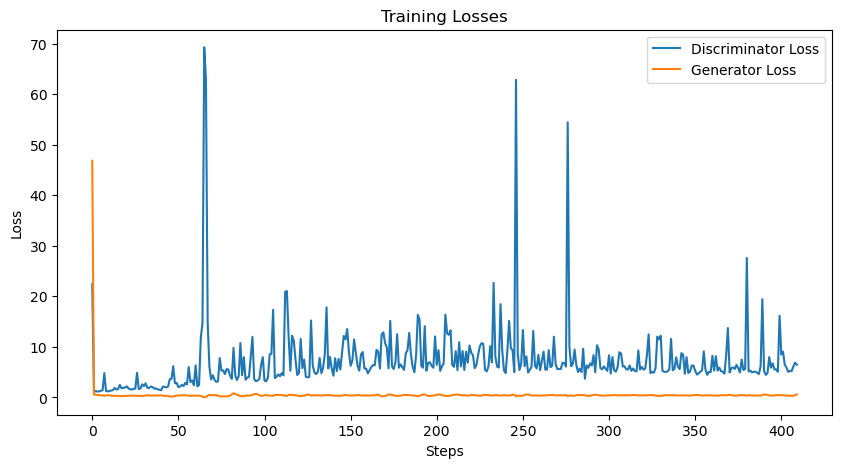

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_loss_d, label='Discriminator Loss')
plt.plot(history_loss_g, label='Generator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

Потери дискриминатора в начале обучения были низкими, что может указывать на то, что дискриминатору в начале было легко различать реальные данные от сгенерированных. Однако со временем потери дискриминатора увеличились и стабилизировались, что может свидетельствовать о том, что дискриминатору стало сложно отличать реальные данные от сгенерированных.

Генератор показывает очень низкую и стабильную потерю после начального пика, что может быть признаком того, что он не получает достаточный градиент для обучения или что дискриминатор стал слишком хорош для текущего состояния генератора. Это может указывать на то, что генератор либо слишком хорошо подстраивается под текущее состояние дискриминатора с самого начала, либо не обучается должным образом, чтобы улучшать свои способности генерации.

Значительная разница между потерями дискриминатора и генератора может быть признаком того, что одна из сетей доминирует над другой. В идеале потери должны сближаться, что указывало бы на то, что обе сети постепенно учатся и улучшают свои способности, и достигается точка равновесия.

Наконец, генерируем песню

In [17]:
sample = model.generate_song()
sample_np = sample.detach().numpy()

df_generated = pd.DataFrame(sample_np, columns=['pitch', 'start', 'end', 'step', 'duration'])
df_generated
#df_generated = df_generated.sort_values(by='start')
#df_generated['start'] = df_generated['start'] + 4 
#df_generated['end'] = df_generated['end'] + 4 
#df_generated['pitch'] = (df_generated['pitch'] + 1) * 64
#df_generated['pitch'] = round(df_generated['pitch'])

,pitch,start,end,step,duration
0,56.0,1.702927,-0.667824,-1.921065,0.226424
1,163.0,1.735409,-3.590945,-1.112274,1.745720
2,-925.0,1.496216,0.860736,0.065164,0.809367
3,-283.0,-2.806150,-0.895900,-1.298588,2.027774
4,278.0,1.250646,0.037619,2.192887,-0.065692
...,...,...,...,...,...
95,77.0,-0.239911,-2.446735,0.630904,1.217528
96,-944.0,1.583801,5.989988,0.652663,1.046831
97,135.0,2.518317,-1.117797,-0.767140,-1.866816
98,414.0,-1.402994,-5.197131,0.580448,-0.776804


Модель генерирует данные, но не учитывает их особенность. Как можно улучшить это?

Улучшения:

    1 pitch сделать категориальным признаком. Тогда столбца pitch следует использовать кросс-энтропийную функцию потерь, так как это задача классификации. Для остальных числовых признаков подходит среднеквадратичная ошибка.
    
    2 убрать end, чтобы не было лин зависимости при обучении
    
    3 рассмотреть WaveNet в качестве декодора, так делает NSynth - https://magenta.tensorflow.org/nsynt На самом деле это сложный декодер. Основная особенность WaveNet – использование дилатационных сверток, которые позволяют сети эффективно работать с временными последовательностями. В WaveNet использует последовательность сверточных слоев с увеличивающимся dilation_rate, что позволяет модели обрабатывать информацию на различных временных масштабах, улавливая как короткие, так и длинные зависимости в аудио сигнале.
   
    4 Временные ряды можно обрабатывать через сверточные слои (для улавливания временных зависимостей), а категориальные данные - через полносвязные слои.
    
    5 Input из tensorflow.keras - работает именно с временными даннами, надо его использовать для start (/ end)

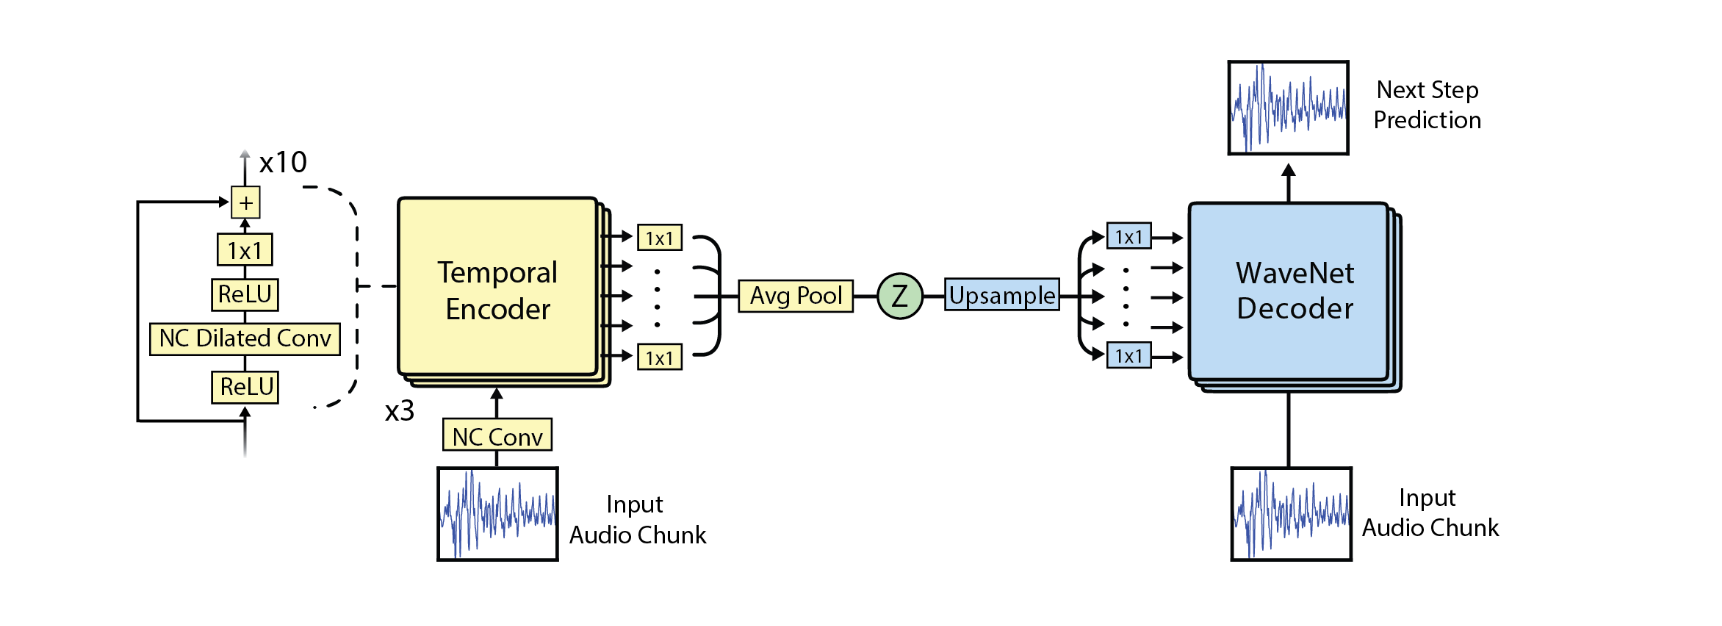

In [85]:
from IPython.display import Image
Image(filename='wavnet.png')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Предположим, что мы имеем размерность входных данных
time_series_dim = 2  # 'start' и 'end'
categorical_dim = 128  # one-hot encoded 'pitch'

# Энкодер
def create_encoder(time_series_dim, categorical_dim):
    # Вход для временных рядов
    time_series_input = Input(shape=(time_series_dim,))
    # Вход для категориальных данных
    categorical_input = Input(shape=(categorical_dim,))
    
    # Обработка временных рядов
    ts = layers.Dense(64, activation='relu')(time_series_input)
    
    # Обработка категориальных данных
    cat = layers.Dense(64, activation='relu')(categorical_input)
    
    # Комбинирование обоих входов
    combined = layers.Concatenate()([ts, cat])
    
    # Скрытое пространство
    z = layers.Dense(32, activation='relu')(combined)
    
    # Энкодер модель
    encoder = Model([time_series_input, categorical_input], z, name='encoder')
    
    return encoder

# Декодер / Генератор
def create_decoder(time_series_dim, categorical_dim):
    latent_inputs = Input(shape=(32,))
    
    # Восстановление временных рядов
    ts = layers.Dense(64, activation='relu')(latent_inputs)
    ts = layers.Dense(time_series_dim)(ts)
    
    # Восстановление категориальных данных
    cat = layers.Dense(64, activation='relu')(latent_inputs)
    cat = layers.Dense(categorical_dim, activation='softmax')(cat)
    
    # Декодер модель
    decoder = Model(latent_inputs, [ts, cat], name='decoder')
    
    return decoder

# Дискриминатор
def create_discriminator(time_series_dim, categorical_dim):
    # Вход для временных рядов
    time_series_input = Input(shape=(time_series_dim,))
    # Вход для категориальных данных
    categorical_input = Input(shape=(categorical_dim,))
    
    # Обработка временных рядов
    ts = layers.Dense(64, activation='relu')(time_series_input)
    
    # Обработка категориальных данных
    cat = layers.Dense(64, activation='relu')(categorical_input)
    
    # Комбинирование обоих входов
    combined = layers.Concatenate()([ts, cat])
    combined = layers.Dense(64, activation='relu')(combined)
    validity = layers.Dense(1, activation='sigmoid')(combined)
    
    # Дискриминатор модель
    discriminator = Model([time_series_input, categorical_input], validity, name='discriminator')
    
    return discriminator

# Создание моделей
encoder = create_encoder(time_series_dim, categorical_dim)
decoder = create_decoder(time_series_dim, categorical_dim)
discriminator = create_discriminator(time_series_dim, categorical_dim)

# Модель VAE
vae_input_ts = Input(shape=(time_series_dim,))
vae_input_cat = Input(shape=(categorical_dim,))
z = encoder([vae_input_ts, vae_input_cat])
reconstructed_ts, reconstructed_cat = decoder(z)

# Определение потерь VAE #отдельно считаем loss на категориальных и временных данных
reconstructed_loss = losses.mean_squared_error(vae_input_ts, reconstructed_ts)
reconstructed_loss += losses.categorical_crossentropy(vae_input_cat, reconstructed_cat)
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstructed_loss + kl_loss)

# Модель VAE-GAN
discriminator.trainable = False
validity = discriminator([reconstructed_ts, reconstructed_cat])

vae_gan = Model(inputs=[vae_input_ts, vae_input_cat], outputs=[reconstructed_ts, reconstructed_cat, validity])

# Определение потерь VAE-GAN
vae_gan.add_loss(vae_loss)
vae_gan.compile(optimizer='adam', loss=[None, None, 'binary_crossentropy'])

# Теперь определим процесс обучения
batch_size = 32
epochs = 1000
# Здесь должен быть ваш код загрузки данных...

# Обучение VAE-GAN
for epoch in range(epochs):
    for batch_i in range(batch_size):
        # Здесь должен быть ваш код получения пакета данных...
        # ...
        
        # Обучение дискриминатора
        discriminator.trainable = True
        # Нужно сгенерировать данные, получить реальные данные, подать их в дискриминатор и обновить его веса
        
        # Обучение VAE-GAN
        discriminator.trainable = False
        # Нужно обновить энкодер и декодер через VAE-GAN модель
        
        # В конце каждой эпохи выводим потери и сохраняем модель, если нужно


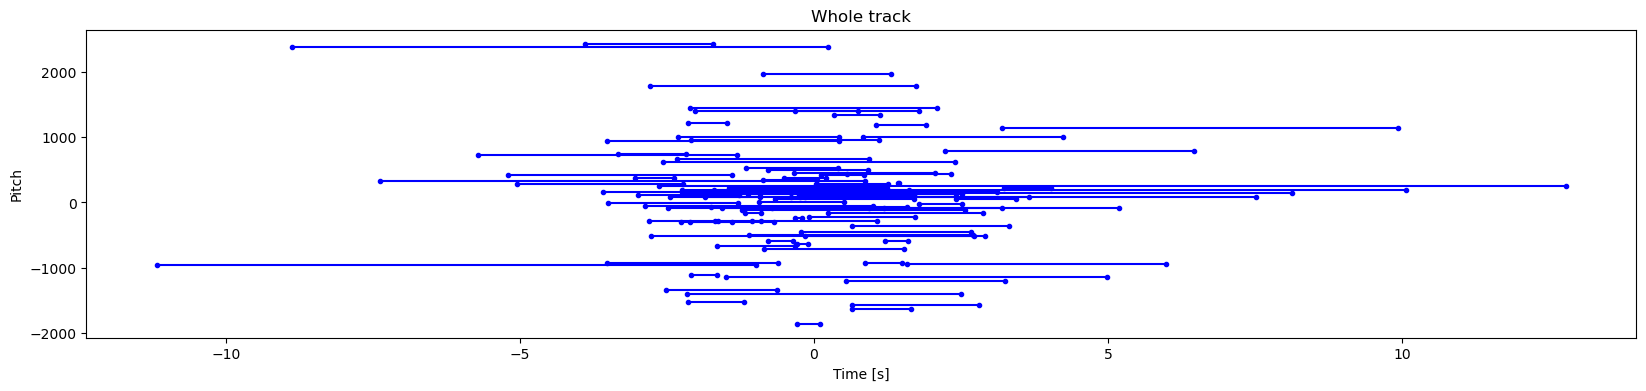

In [18]:
# Рисуем piano_roll нашего сгенерированного аудио
plot_piano_roll(df_generated)

Сохраняем сгенерированный файл в 'output.mid'

In [19]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'output.mid'
out_pm = notes_to_midi(df_generated, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

ValueError: data byte must be in range 0..127

## Сэмплируем из VAE, не VAEGAN. ЭТО МОЖНО НЕ СМОТРЕТЬ

In [ ]:
# vae из model
from model import VAE

beta=0.3
vae = VAE(100 * 5, 100)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
criterion = nn.MSELoss()
for data in dataloader:
    print(data.shape)
    optimizer.zero_grad()
    out, loss_kl = vae(data)
    rec_loss = criterion(out, data)
    loss = rec_loss + beta * loss_kl
    loss.backward()
    optimizer.step()

In [ ]:
sample = vae.sample_vae(1)[0]
sample_np = sample.detach().numpy()
sample_np
df_generated = pd.DataFrame(sample_np, columns=['pitch', 'start', 'end', 'step', 'duration'])
df_generated

In [ ]:
plot_piano_roll(df_generated)

In [ ]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'output.mid'
out_pm = notes_to_midi(df_generated, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)